# **Setup**

###First time executing

Set the ***first_time_executing*** variable to ***True*** if it's the first time executing the notebook

After executed, it will ask you to upload a file needed to download the dataset directly into Google Colab. To obtain that file:

*   Go to [Kaggle.com](https://www.kaggle.com/)
*   Go to your account
*   Under the voice API select "*Create new Token*"

This will download a *kaggle.json* file. Please upload that file in order to continue.

<br/>

#####**More info:**
The file contains your personal Kaggle API key: it will allow to download the dataset directly into Google Colab without downloading it in Google Drive beforehand (and without mounting the Drive).

The dataset will be unzipped directly in the current working directory (/content).

<br/>

#####**For Group Members**:
If you want to change dataset please change the variable *dataset_full_name* with the new dataset full name.
A dataset full name is given by the username of the creator + the name of the dataset. You can find it from the URL of the dataset page:

e.g. from https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset you take only "*pranavraikokte/covid19-image-dataset*"

In [ ]:
first_time_executing = True

if first_time_executing:

  from google.colab import files
  import os

  !pip install -q kaggle

  # Please upload the kaggle.json file you downlad from going to kaggle.com > Your account > API > Create new Token
  files.upload()

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_full_name = "tawsifurrahman/covid19-radiography-database/" # The dataset name must be: Username/Dataset_name
  !kaggle datasets download {dataset_full_name}

  dataset_name = os.path.basename(os.path.normpath(dataset_full_name))
  !unzip {dataset_name}.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  

### Imports and Parameters

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import random
import torch.nn as nn
import torch.nn.functional as F
import csv
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

dataset_path = 'COVID-19_Radiography_Dataset'
balanced_dataset_path = 'COVID-19_Radiography_Dataset_Balanced'
new_dataset_name = 'Covid_Dataset'
train_csv_path = 'train.csv'
test_csv_path = 'test.csv'
train_dir = os.path.join(new_dataset_name, 'train')
test_dir = os.path.join(new_dataset_name, 'test')

# classes = ['COVID', 'Normal', 'Viral Pneumonia']
classes = ['COVID', 'Normal']
NUM_CLASSES = 2

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.09
TEST_SIZE = 0.2
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

normalize = False

torch.manual_seed(SEED)
random.seed(SEED)

#**Preprocessing**

### Data Balancing

#####Delete Lung Opacity Class

In [ ]:
shutil.copytree(dataset_path, balanced_dataset_path)

lung_opacity_dir = os.path.join(balanced_dataset_path, 'Lung_Opacity')

try:
  shutil.rmtree(lung_opacity_dir)
  print(f"Successfully deleted: {lung_opacity_dir}")
except OSError as e:
  print(f"Error: {lung_opacity_dir} - {e}")

Successfully deleted: COVID-19_Radiography_Dataset_Balanced/Lung_Opacity


#####Balance Normal and Covid class

In [ ]:
normal_images_path = os.path.join(balanced_dataset_path, 'Normal', 'images')
num_covid_images = len(os.listdir(os.path.join(balanced_dataset_path, 'COVID', 'images')))
normal_image_files = os.listdir(normal_images_path)

print(f'Before: {num_covid_images} Covid images / {len(normal_image_files)} Normal images')

images_to_delete = random.sample(normal_image_files, len(normal_image_files) - num_covid_images)
for image_file in images_to_delete:
  image_path = os.path.join(normal_images_path, image_file)
  os.remove(image_path)

print(f'After: {num_covid_images} Covid images / {len(os.listdir(normal_images_path))} Normal images')

Before: 3616 Covid images / 10192 Normal images
After: 3616 Covid images / 3616 Normal images


#####CSV creation, Create the new dataset folder, Convert all images to grayscale

In [ ]:
# Search for every image in the dataset, register the name and class within a CSV (train or test), convert the non-gray image into gray images (needed to calculate mean and std for Normalization) and move all the images into a new dataset folder partitioned train/test

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

class_encoding = {class_name: idx for idx, class_name in enumerate(classes)}

with open(train_csv_path, 'w', newline='') as train_csv_file, open(test_csv_path, 'w', newline='') as test_csv_file:
  train_csv_writer = csv.writer(train_csv_file)
  test_csv_writer = csv.writer(test_csv_file)

  # Header
  train_csv_writer.writerow(['Index_Name', 'Class'])
  test_csv_writer.writerow(['Index_Name', 'Class'])

  for class_name in classes:
    class_dir = os.path.join(balanced_dataset_path, class_name, 'images')
    images = os.listdir(class_dir)

    train_images, test_images = train_test_split(images, test_size=TEST_SIZE, random_state=SEED)

    for image in train_images:
      # Write into the CSV
      index_name = f"{image}"
      class_label = class_encoding[class_name]
      train_csv_writer.writerow([index_name, class_label])

      # Move files
      source_path = os.path.join(class_dir, image)
      pre_image = np.array(Image.open(source_path))

      # Check if they are not grey scale
      if len(pre_image.shape) > 2:
        grayscale_image = np.dot(pre_image[..., :3], [0.299, 0.587, 0.114])
        grayscale_image = Image.fromarray(grayscale_image.astype(np.uint8))
        os.remove(source_path)
        grayscale_image.save(source_path)
        print('Modified: ', source_path)

      if os.path.exists(source_path) == True:
        destination_path = os.path.join(train_dir, image)
        shutil.copy(source_path, destination_path)
      else:
        raise Exception('FILE NOT FOUND')

    for image in test_images:
      index_name = f"{image}"
      class_label = class_encoding[class_name]
      test_csv_writer.writerow([index_name, class_label])

      source_path = os.path.join(class_dir, image)
      pre_image = np.array(Image.open(source_path))

      if len(pre_image.shape) > 2:
        grayscale_image = np.dot(pre_image[..., :3], [0.299, 0.587, 0.114])
        grayscale_image = Image.fromarray(grayscale_image.astype(np.uint8))
        os.remove(source_path)
        grayscale_image.save(source_path)
        print('Modified: ', source_path)

      if os.path.exists(source_path) == True:
        destination_path = os.path.join(test_dir, image)
        shutil.copy(source_path, destination_path)
      else:
        raise Exception('FILE NOT FOUND')

Check if there is a non-grayscale image

In [ ]:
from PIL import Image
import os

def is_grayscale(image_path):
    # Open the image
    img = Image.open(image_path)

    # Check if it's a grayscale image
    return img.mode == 'L'

for root, dirs, files in os.walk(new_dataset_name):
    for file in files:

        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(root, file)
            if not is_grayscale(image_path):
              raise Exception('Error: Multiple channels detected')
        else:
          raise Exception('Error: File format not supported')
print("All the images are grayscale")


All the images are grayscale


### Checkings

##### Plot class occurrencies

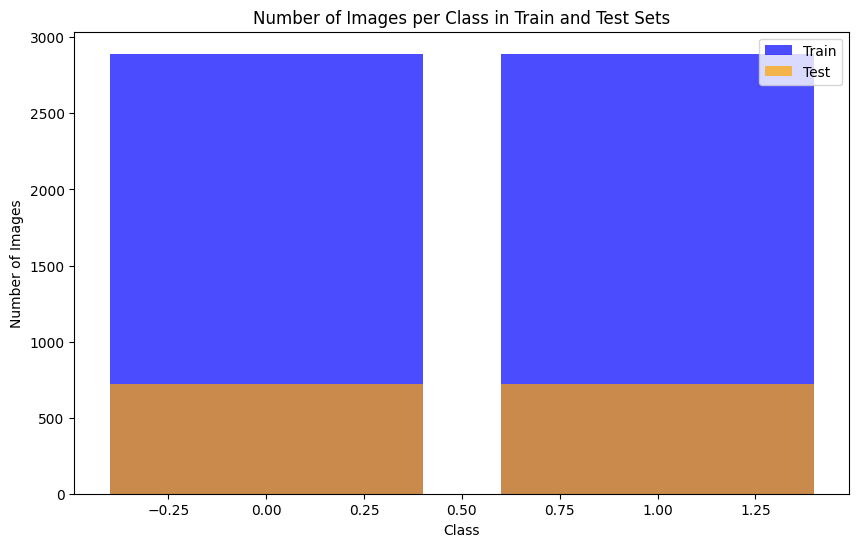

In [ ]:
import pandas as pd

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

train_counts = train_df['Class'].value_counts().sort_index()
test_counts = test_df['Class'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

plt.bar(train_counts.index, train_counts.values, color='blue', alpha=0.7, label='Train')
plt.bar(test_counts.index, test_counts.values, color='orange', alpha=0.7, label='Test')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train and Test Sets')
plt.legend()
plt.show()

##### Check image dimensions

In [ ]:
# All images should be 299 x 299, This script doesn't check the channels

from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

# Loop through each image in the training folder
train_prev_dim = (0,0)
test_prev_dim = (0,0)
for img in os.listdir(train_dir):
  if img.endswith(".jpg") or img.endswith(".png"):
    img_path = os.path.join(train_dir, img)
    dimensions = get_image_dimensions(img_path)

    if train_prev_dim != dimensions:
      print("Train image dimensions: ", dimensions)
      train_prev_dim = dimensions

for img in os.listdir(test_dir):
  if img.endswith(".jpg") or img.endswith(".png"):
    img_path = os.path.join(test_dir, img)
    dimensions = get_image_dimensions(img_path)

    if test_prev_dim != dimensions:
      print("Test image dimensions: ", dimensions)
      test_prev_dim = dimensions

Train image dimensions:  (299, 299)
Test image dimensions:  (299, 299)


# **Prepare Dataset**

### Dataset creation

In [ ]:
# from torchvision.transforms import v2
import torchvision.transforms as v2
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader

resizedTransform = v2.Compose([
  # v2.RandomResizedCrop(size=(224, 224), antialias=True),
  # v2.RandomHorizontalFlip(p=0.5),
  # ToFloatTensor()
  v2.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
  # v2.ToDtype(torch.float32, scale=True)
  # v2.Normalize(mean=[0.485], std=[0.229]),
  v2.Resize(size=(150,150))
])

class CovidDataset(Dataset):
  def __init__(self, train_images_folder, test_images_folder, path_to_train_csv, path_to_test_csv, train=True, transform=None):
    super().__init__()
    self.train_data = pd.read_csv(path_to_train_csv)
    self.test_data = pd.read_csv(path_to_test_csv)
    self.train_images_folder = train_images_folder
    self.test_images_folder = test_images_folder
    self.images_files = os.listdir(train_images_folder)
    self.transform = transform
    self.train = train

  def __len__(self):
    return self.train_data.shape[0] if self.train else self.test_data.shape[0]

  def __getitem__(self, index):
    if self.train:
      image_file, label = self.train_data.iloc[index]
      image = np.array(Image.open(os.path.join(self.train_images_folder, image_file)))
    else:
      image_file, label = self.test_data.iloc[index]
      image = np.array(Image.open(os.path.join(self.test_images_folder, image_file)))

    if self.transform:
      # image = self.transform(image)["image"]
      image = self.transform(image)



    return image, label, image_file

###Dataset Normalization

In [ ]:
# if you think data can fit in your memory, change it_fits to True
if normalize:

# Compute mean and std of the data
  it_fits = False

  dataset = CovidDataset(
    train_images_folder = train_dir,
    test_images_folder = test_dir,
    path_to_train_csv = train_csv_path,
    path_to_test_csv = test_csv_path,
    transform = resizedTransform
  )

  if it_fits:
    loader = DataLoader(
      dataset=dataset, batch_size=len(pd.read_csv(train_csv_path)), num_workers=1, shuffle=True, pin_memory=True
    )
    data = next(iter(loader))
    mean = data[0].mean()
    std = data[0].std()
    print('Mean: ', mean, '\nStd: ', std)

  else:

    loader = DataLoader(
      dataset=dataset, batch_size=1000, num_workers=0, shuffle=True, pin_memory=True
    )
    num_of_pixels = len(pd.read_csv(train_csv_path)) *299*299
    total_sum = 0
    for batch in loader:
      total_sum += batch[0].sum()
      # since get item returned image, label, name_of_the_image, batch is composed of 3 elements: [0]: series of 1000 images, [1]: series of 1000 labels, [2]: series of 1000 image names
    mean = total_sum/num_of_pixels

    sum_of_squared_error = 0
    for batch in loader:
      sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
    std = torch.sqrt(sum_of_squared_error/num_of_pixels)

    print('Mean pre-normalization: ', mean)
    print('Standard Deviation pre-normalization: ', std)

  # Plot not normalized data

  num_bins = 50
  hist_sum = np.zeros(num_bins)
  # Define bin edges explicitly for the range [0, 1]
  bin_edges = np.linspace(-2, 2, num_bins + 1)
  for batch in loader:
      batch_data = batch[0].numpy()
      hist_batch, _ = np.histogram(batch_data, bins=bin_edges)
      hist_sum += hist_batch

  plt.bar(bin_edges[:-1], hist_sum, width=(bin_edges[1] - bin_edges[0]))
  plt.axvline(mean)
  plt.show()

  # Normalize the data
#ACTIVE FOR FC
  #resizedTransform = v2.Compose([
  #  v2.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
  #  v2.Resize(size=(150,150)),
  #  v2.Normalize(mean=mean, std=std)
  #])

  normDataset = CovidDataset(
    train_images_folder = train_dir,
    test_images_folder = test_dir,
    path_to_train_csv = train_csv_path,
    path_to_test_csv = test_csv_path,
    transform = resizedTransform
  )

  normLoader = DataLoader(
    dataset=normDataset, batch_size=1000, num_workers=0, shuffle=True, pin_memory=True
  )

  num_of_pixels = len(pd.read_csv(train_csv_path)) *299*299
  total_sum = 0
  for batch in normLoader:
    total_sum += batch[0].sum()
    # since get item returned image, label, name_of_the_image, batch is composed of 3 elements: [0]: series of 1000 images, [1]: series of 1000 labels, [2]: series of 1000 image names
  mean = total_sum/num_of_pixels

  sum_of_squared_error = 0
  for batch in normLoader:
    sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
  std = torch.sqrt(sum_of_squared_error/num_of_pixels)

  print('Mean post-normalization: ', mean)
  print('Standard Deviation post-normalization: ', std)

  # Plot normalize data

  num_bins = 50
  hist_sum = np.zeros(num_bins)
  # Define bin edges explicitly for the range [0, 1]
  bin_edges = np.linspace(-2, 2, num_bins + 1)
  for batch in normLoader:
      batch_data = batch[0].numpy()
      hist_batch, _ = np.histogram(batch_data, bins=bin_edges)
      hist_sum += hist_batch

  plt.bar(bin_edges[:-1], hist_sum, width=(bin_edges[1] - bin_edges[0]))
  plt.axvline(mean)
  plt.show()

# **Create the Networks**

###Setup

#####Train and Test data loading

In [ ]:
train_dataset = CovidDataset(
  train_images_folder = train_dir,
  test_images_folder = test_dir,
  path_to_train_csv = train_csv_path,
  path_to_test_csv = test_csv_path,
  transform = resizedTransform
)

test_dataset = CovidDataset(
  train_images_folder = train_dir,
  test_images_folder = test_dir,
  path_to_train_csv = train_csv_path,
  path_to_test_csv = test_csv_path,
  train = False,
  transform = resizedTransform
)

train_loader = DataLoader(
  dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, pin_memory=True
)

test_loader = DataLoader(
  dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True
)

#####Networks creation

In [ ]:
# class ConvNet(nn.Module):
#   def __init__(self):
#     super(ConvNet, self).__init__()
#     self.conv1 = nn.Conv2d(1, 8, 3)
#     self.pool = nn.MaxPool2d(2, 2) # kernel size 2 and stride 2
#     self.conv2 = nn.Conv2d(8, 16, 3)
#     # self.conv3 = nn.Conv2d(16, 32, 3)
#     # self.conv4 = nn.Conv2d(10, 12, 3)

#     self.fc1 = nn.Linear(16*73*73, 10000)
#     self.fc2 = nn.Linear(10000, NUM_CLASSES)
#     # self.fc2 = nn.Linear(10000, 500)
#     # self.fc3 = nn.Linear(500, NUM_CLASSES)


#   def forward(self, x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     # x = self.pool(F.relu(self.conv3(x)))
#     # x = self.pool(F.relu(self.conv4(x)))
#     x = x.view(-1, 16*73*73)
#     x = F.relu(self.fc1(x))
#     x = self.fc2(x)
#     return x

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.pool = nn.MaxPool2d(2, 2) # kernel size 2 and stride 2
    self.conv2 = nn.Conv2d(8, 16, 3)
    # self.conv3 = nn.Conv2d(16, 32, 3)
    # self.conv4 = nn.Conv2d(10, 12, 3)

    self.fc1 = nn.Linear(16*36*36, 5000)
    self.fc2 = nn.Linear(5000, NUM_CLASSES)
    # self.fc2 = nn.Linear(10000, 500)
    # self.fc3 = nn.Linear(500, NUM_CLASSES)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # x = self.pool(F.relu(self.conv3(x)))
    # x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 16*36*36)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

class FCNet(nn.Module):
   def __init__(self):
     super(FCNet, self).__init__()
     self.fc1 = nn.Linear(150*150, 5000)
     self.fc2 = nn.Linear(5000, 100)
     self.fc3 = nn.Linear(100, NUM_CLASSES)
     self.dropout1 = nn.Dropout2d(0.25)
     self.dropout2 = nn.Dropout2d(0.5)


   def forward(self, x):
     x = x.view(-1, 150*150)
     x = F.relu(self.fc1(x))
     x = self.dropout1(x)
     x = F.relu(self.fc2(x))
     x = self.dropout2(x)
     x = self.fc3(x)
     return x

#class FCNet(nn.Module):
#  def __init__(self):
#    super(FCNet, self).__init__()
#    self.fc1 = nn.Linear(150*150, 5000)
#    self.fc2 = nn.Linear(5000, 500)
#    self.fc3 = nn.Linear(500, 50)
#    self.fc4 = nn.Linear(50, NUM_CLASSES)
#    self.dropout1 = nn.Dropout2d(0.25)
#    self.dropout2 = nn.Dropout2d(0.5)


#  def forward(self, x):
#    x = x.view(-1, 150*150)
#    x = F.relu(self.fc1(x))
#    x = self.dropout1(x)
#    x = F.relu(self.fc2(x))
#    x = F.relu(self.fc3(x))
#    x = self.dropout2(x)
#     x = self.fc4(x)
#    return x

###Train and Test

#####Convolutional Neural Network

####Cross validation

In [ ]:
import os
import shutil

# Define the paths to your directories
train_dir = 'Covid_Dataset/train'
test_dir = 'Covid_Dataset/test'
full_dir = 'Covid_Dataset/full'

# Function to copy files from a source directory to a destination directory
def copy_files(src_dir, dst_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Copy each file from the source directory to the destination directory
    for filename in os.listdir(src_dir):
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)

        # Check if the file doesn't already exist in the destination directory
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"File {filename} already exists in the destination directory.")

# Copy files from train and test directories to the full directory
copy_files(train_dir, full_dir)
copy_files(test_dir, full_dir)

print("Files have been copied to the 'full' directory.")



Files have been copied to the 'full' directory.


In [ ]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class CombinedDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder = folder
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)

        class_encoding = {class_name: idx for idx, class_name in enumerate(classes)}

        if self.transform:
            image = self.transform(image)

        # Here we assume that the label is part of the file name format: "class_label_imagename.jpg"
        # You will need to modify this part to fit your naming convention or labeling method.
        label_str = img_name.split(os.sep)[-1].split('-')[0]  # Change this line to extract label from the filename
        label = class_encoding[label_str] # Convert label to integer if necessary

        return image, label

In [ ]:
Learning_rates = [0.09]
precisions = []
recalls = []
BATCH_SIZE = 32
NUM_EPOCHS = 40
accuracy_changing_learning_rates8=[]

FOLD 0
--------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:18<00:00,  9.88it/s]

  2%|▎         | 1/40 [00:35<23:09, 35.62s/it]


FC Precision:  0.6755725190839694
FC Recall:  0.7334254143646409
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:18<00:00,  9.93it/s]

  5%|▌         | 2/40 [01:18<25:12, 39.81s/it]


FC Precision:  0.6064516129032258
FC Recall:  0.9088397790055248
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.71it/s]

  8%|▊         | 3/40 [01:49<22:12, 36.02s/it]


FC Precision:  0.8027777777777778
FC Recall:  0.39917127071823205
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.60it/s]

 10%|█         | 4/40 [02:21<20:33, 34.26s/it]


FC Precision:  0.5317577548005908
FC Recall:  0.994475138121547
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.46it/s]

 12%|█▎        | 5/40 [02:53<19:33, 33.54s/it]


FC Precision:  0.7566964285714286
FC Recall:  0.468232044198895
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.75it/s]

 15%|█▌        | 6/40 [03:25<18:37, 32.87s/it]


FC Precision:  0.8104738154613467
FC Recall:  0.4488950276243094
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 1 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.67it/s]

 18%|█▊        | 7/40 [03:57<17:57, 32.66s/it]


FC Precision:  0.8164893617021277
FC Recall:  0.4240331491712707
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.70it/s]

 20%|██        | 8/40 [04:29<17:16, 32.39s/it]


FC Precision:  0.9712230215827338
FC Recall:  0.18646408839779005
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.58it/s]

 22%|██▎       | 9/40 [05:01<16:37, 32.18s/it]


FC Precision:  0.7650485436893204
FC Recall:  0.5441988950276243
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.44it/s]

 25%|██▌       | 10/40 [05:33<16:11, 32.39s/it]


FC Precision:  0.772256728778468
FC Recall:  0.5151933701657458
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.54it/s]

 28%|██▊       | 11/40 [06:05<15:35, 32.26s/it]


FC Precision:  0.6954838709677419
FC Recall:  0.744475138121547
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.62it/s]

 30%|███       | 12/40 [06:38<15:08, 32.46s/it]


FC Precision:  0.7527472527472527
FC Recall:  0.5676795580110497
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.56it/s]

 32%|███▎      | 13/40 [07:12<14:45, 32.79s/it]


FC Precision:  0.6636363636363637
FC Recall:  0.8066298342541437
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.35it/s]

 35%|███▌      | 14/40 [07:45<14:15, 32.90s/it]


FC Precision:  0.8059701492537313
FC Recall:  0.5220994475138122
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.12it/s]

 38%|███▊      | 15/40 [08:18<13:42, 32.91s/it]


FC Precision:  0.7121418826739427
FC Recall:  0.7209944751381215
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.43it/s]

 40%|████      | 16/40 [08:51<13:07, 32.82s/it]


FC Precision:  0.8920454545454546
FC Recall:  0.43370165745856354
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.97it/s]

 42%|████▎     | 17/40 [09:24<12:38, 32.97s/it]


FC Precision:  0.9245283018867925
FC Recall:  0.40607734806629836
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.37it/s]

 45%|████▌     | 18/40 [09:56<12:02, 32.84s/it]


FC Precision:  1.0
FC Recall:  0.12292817679558012
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.13it/s]

 48%|████▊     | 19/40 [10:30<11:32, 32.99s/it]


FC Precision:  0.734472049689441
FC Recall:  0.6533149171270718
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.55it/s]

 50%|█████     | 20/40 [11:02<10:54, 32.73s/it]


FC Precision:  0.6638023630504833
FC Recall:  0.8535911602209945
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.20it/s]

 52%|█████▎    | 21/40 [11:35<10:25, 32.94s/it]


FC Precision:  0.6836861768368617
FC Recall:  0.7582872928176796
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.34it/s]

 55%|█████▌    | 22/40 [12:08<09:52, 32.89s/it]


FC Precision:  0.892
FC Recall:  0.3080110497237569
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.34it/s]

 57%|█████▊    | 23/40 [12:41<09:17, 32.80s/it]


FC Precision:  0.5994787141615986
FC Recall:  0.9530386740331491
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.12it/s]

 60%|██████    | 24/40 [13:14<08:48, 33.06s/it]


FC Precision:  0.956
FC Recall:  0.3301104972375691
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.40it/s]

 62%|██████▎   | 25/40 [13:47<08:12, 32.85s/it]


FC Precision:  0.6252354048964218
FC Recall:  0.9171270718232044
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.32it/s]

 65%|██████▌   | 26/40 [14:20<07:42, 33.07s/it]


FC Precision:  0.9741379310344828
FC Recall:  0.15607734806629833
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.32it/s]

 68%|██████▊   | 27/40 [14:53<07:08, 32.92s/it]


FC Precision:  0.7568493150684932
FC Recall:  0.6104972375690608
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.09it/s]

 70%|███████   | 28/40 [15:26<06:36, 33.07s/it]


FC Precision:  1.0
FC Recall:  0.03038674033149171
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.27it/s]

 72%|███████▎  | 29/40 [15:59<06:03, 33.08s/it]


FC Precision:  0.8281573498964804
FC Recall:  0.5524861878453039
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.28it/s]

 75%|███████▌  | 30/40 [16:32<05:29, 32.95s/it]


FC Precision:  0.6967005076142132
FC Recall:  0.7582872928176796
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [1 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.91it/s]

 78%|███████▊  | 31/40 [17:06<04:59, 33.22s/it]


FC Precision:  0.8547486033519553
FC Recall:  0.42265193370165743
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.25it/s]

 80%|████████  | 32/40 [17:38<04:24, 33.04s/it]


FC Precision:  0.9360902255639098
FC Recall:  0.34392265193370164
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.22it/s]

 82%|████████▎ | 33/40 [18:12<03:52, 33.22s/it]


FC Precision:  0.9767441860465116
FC Recall:  0.058011049723756904
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.16it/s]

 85%|████████▌ | 34/40 [18:45<03:18, 33.12s/it]


FC Precision:  0.8373626373626374
FC Recall:  0.5262430939226519
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.23it/s]

100%|██████████| 46/46 [00:03<00:00, 12.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|████████▊ | 35/40 [19:18<02:45, 33.10s/it]


FC Precision:  0.0
FC Recall:  0.0
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.58it/s]

 90%|█████████ | 36/40 [19:52<02:13, 33.41s/it]


FC Precision:  0.8794642857142857
FC Recall:  0.27209944751381215
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.93it/s]

 92%|█████████▎| 37/40 [20:26<01:40, 33.40s/it]


FC Precision:  0.8647058823529412
FC Recall:  0.40607734806629836
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.64it/s]

 95%|█████████▌| 38/40 [21:01<01:08, 34.08s/it]


FC Precision:  0.8357843137254902
FC Recall:  0.47099447513812154
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.15it/s]

 98%|█████████▊| 39/40 [21:34<00:33, 33.81s/it]


FC Precision:  0.7103896103896103
FC Recall:  0.755524861878453
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.96it/s]

100%|██████████| 40/40 [22:08<00:00, 33.21s/it]



FC Precision:  0.7400611620795107
FC Recall:  0.6685082872928176
Labels:  [0 0 1 ... 0 0 0] 

Predicted:  [0 0 0 ... 0 1 1] 

[0.7166551485832757]


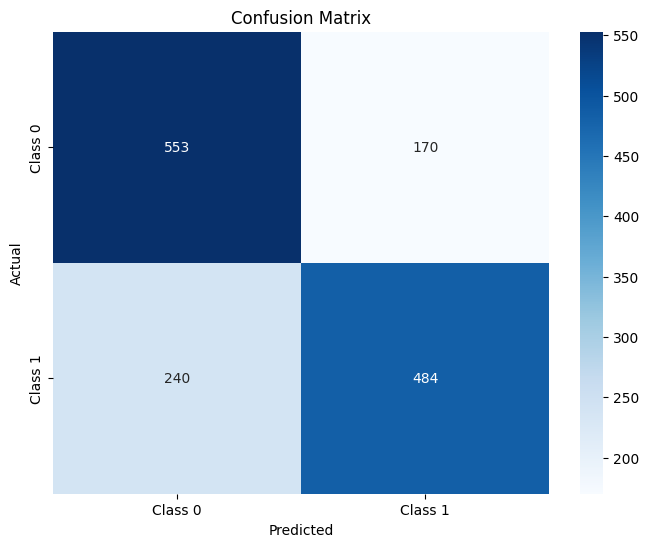

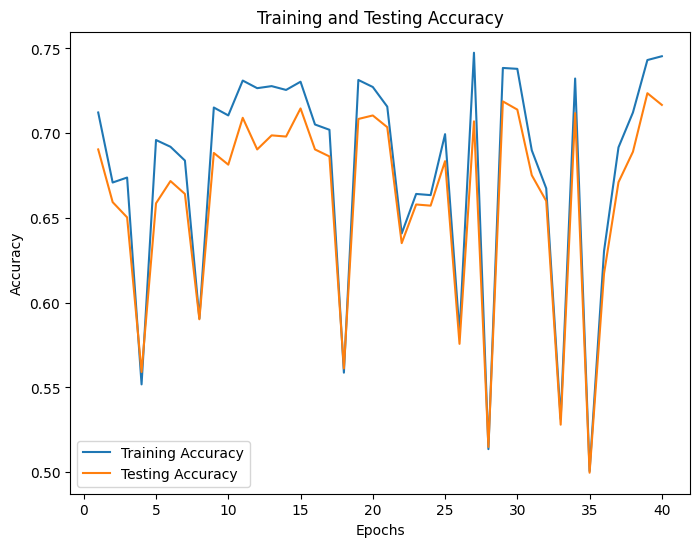

FOLD 1
--------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:14<00:00, 12.11it/s]

  2%|▎         | 1/40 [00:33<21:44, 33.46s/it]


FC Precision:  0.632368703108253
FC Recall:  0.8464849354375896
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.84it/s]

  5%|▌         | 2/40 [01:07<21:20, 33.70s/it]


FC Precision:  0.8843537414965986
FC Recall:  0.37302725968436157
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.31it/s]

  8%|▊         | 3/40 [01:42<21:10, 34.35s/it]


FC Precision:  0.9855072463768116
FC Recall:  0.1951219512195122
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.65it/s]

 10%|█         | 4/40 [02:17<20:40, 34.46s/it]


FC Precision:  0.7134670487106017
FC Recall:  0.7144906743185079
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.91it/s]

 12%|█▎        | 5/40 [02:53<20:32, 35.21s/it]


FC Precision:  0.575152041702867
FC Recall:  0.9497847919655668
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.54it/s]

 15%|█▌        | 6/40 [03:28<19:51, 35.06s/it]


FC Precision:  0.7290715372907154
FC Recall:  0.6872309899569584
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.77it/s]

 18%|█▊        | 7/40 [04:03<19:19, 35.13s/it]


FC Precision:  0.7521815008726004
FC Recall:  0.6183644189383071
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.70it/s]

 20%|██        | 8/40 [04:38<18:36, 34.90s/it]


FC Precision:  0.9428571428571428
FC Recall:  0.28407460545193686
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.63it/s]

 22%|██▎       | 9/40 [05:12<18:00, 34.85s/it]


FC Precision:  0.6350515463917525
FC Recall:  0.8837876614060258
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.43it/s]

 25%|██▌       | 10/40 [05:47<17:24, 34.81s/it]


FC Precision:  0.6375908618899273
FC Recall:  0.8809182209469153
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 12.00it/s]

 28%|██▊       | 11/40 [06:21<16:39, 34.46s/it]


FC Precision:  0.6261127596439169
FC Recall:  0.9081779053084649
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 1 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.24it/s]

 30%|███       | 12/40 [06:56<16:16, 34.86s/it]


FC Precision:  0.8238095238095238
FC Recall:  0.4964131994261119
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.76it/s]

 32%|███▎      | 13/40 [07:30<15:33, 34.57s/it]


FC Precision:  0.6971279373368147
FC Recall:  0.7661406025824964
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.62it/s]

 35%|███▌      | 14/40 [08:06<15:03, 34.75s/it]


FC Precision:  0.797071129707113
FC Recall:  0.5466284074605452
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.69it/s]

 38%|███▊      | 15/40 [08:40<14:25, 34.60s/it]


FC Precision:  0.7805429864253394
FC Recall:  0.4949784791965567
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.62it/s]

 40%|████      | 16/40 [09:15<13:52, 34.69s/it]


FC Precision:  0.7433489827856025
FC Recall:  0.6814921090387375
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.27it/s]

 42%|████▎     | 17/40 [09:50<13:25, 35.02s/it]


FC Precision:  0.8323863636363636
FC Recall:  0.42037302725968434
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.48it/s]

 45%|████▌     | 18/40 [10:25<12:47, 34.88s/it]


FC Precision:  0.7410714285714286
FC Recall:  0.7144906743185079
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.53it/s]

 48%|████▊     | 19/40 [11:01<12:18, 35.18s/it]


FC Precision:  0.7329462989840348
FC Recall:  0.7245337159253945
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.51it/s]

 50%|█████     | 20/40 [11:36<11:40, 35.00s/it]


FC Precision:  0.7507462686567165
FC Recall:  0.7216642754662841
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.56it/s]

 52%|█████▎    | 21/40 [12:11<11:05, 35.01s/it]


FC Precision:  0.9837837837837838
FC Recall:  0.2611190817790531
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.50it/s]

 55%|█████▌    | 22/40 [12:48<10:44, 35.79s/it]


FC Precision:  0.8161434977578476
FC Recall:  0.5222381635581061
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.11it/s]

 57%|█████▊    | 23/40 [13:24<10:09, 35.82s/it]


FC Precision:  0.6966824644549763
FC Recall:  0.8436154949784792
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.47it/s]

 60%|██████    | 24/40 [13:59<09:30, 35.63s/it]


FC Precision:  0.7908256880733945
FC Recall:  0.6183644189383071
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:15<00:00, 11.38it/s]

 62%|██████▎   | 25/40 [14:35<08:56, 35.77s/it]


FC Precision:  0.8904109589041096
FC Recall:  0.5595408895265424
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.14it/s]

 65%|██████▌   | 26/40 [15:11<08:19, 35.71s/it]


FC Precision:  0.8101851851851852
FC Recall:  0.5021520803443329
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.95it/s]

 68%|██████▊   | 27/40 [15:49<07:52, 36.36s/it]


FC Precision:  0.8208092485549133
FC Recall:  0.6111908177905309
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.89it/s]

 70%|███████   | 28/40 [16:26<07:18, 36.54s/it]


FC Precision:  0.6755260243632336
FC Recall:  0.8751793400286944
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.92it/s]

 72%|███████▎  | 29/40 [17:02<06:41, 36.52s/it]


FC Precision:  0.7656012176560122
FC Recall:  0.7216642754662841
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.59it/s]

 75%|███████▌  | 30/40 [17:40<06:08, 36.89s/it]


FC Precision:  0.9900990099009901
FC Recall:  0.14347202295552366
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 11.10it/s]

 78%|███████▊  | 31/40 [18:16<05:29, 36.66s/it]


FC Precision:  0.921875
FC Recall:  0.4232424677187948
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.91it/s]

 80%|████████  | 32/40 [18:53<04:55, 36.89s/it]


FC Precision:  0.8559782608695652
FC Recall:  0.4519368723098996
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.87it/s]

 82%|████████▎ | 33/40 [19:30<04:17, 36.83s/it]


FC Precision:  0.8333333333333334
FC Recall:  0.5164992826398852
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.16it/s]

 85%|████████▌ | 34/40 [20:09<03:45, 37.54s/it]


FC Precision:  0.8908045977011494
FC Recall:  0.4447632711621234
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 0 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:22<00:00,  8.11it/s]

 88%|████████▊ | 35/40 [20:58<03:24, 40.92s/it]


FC Precision:  0.7511045655375552
FC Recall:  0.7317073170731707
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.82it/s]

 90%|█████████ | 36/40 [21:39<02:43, 40.98s/it]


FC Precision:  0.810204081632653
FC Recall:  0.569583931133429
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.46it/s]

 92%|█████████▎| 37/40 [22:18<02:00, 40.18s/it]


FC Precision:  0.7781299524564184
FC Recall:  0.7044476327116213
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 1 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:16<00:00, 10.78it/s]

 95%|█████████▌| 38/40 [22:55<01:18, 39.37s/it]


FC Precision:  0.7743431221020093
FC Recall:  0.7187948350071736
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [1 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.48it/s]

 98%|█████████▊| 39/40 [23:33<00:39, 39.01s/it]


FC Precision:  0.7704160246533128
FC Recall:  0.7173601147776184
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.50it/s]

100%|██████████| 40/40 [24:11<00:00, 36.28s/it]



FC Precision:  0.8118081180811808
FC Recall:  0.6312769010043041
Labels:  [1 0 1 ... 0 1 1] 

Predicted:  [0 0 1 ... 0 1 1] 

[0.7166551485832757, 0.7519004837595025]


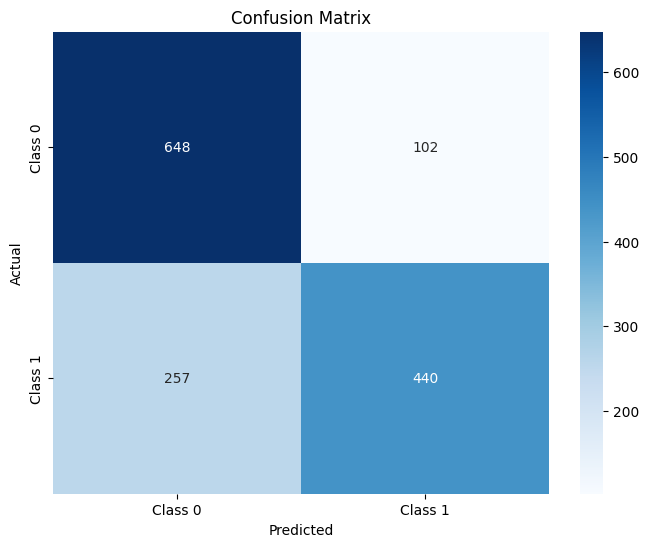

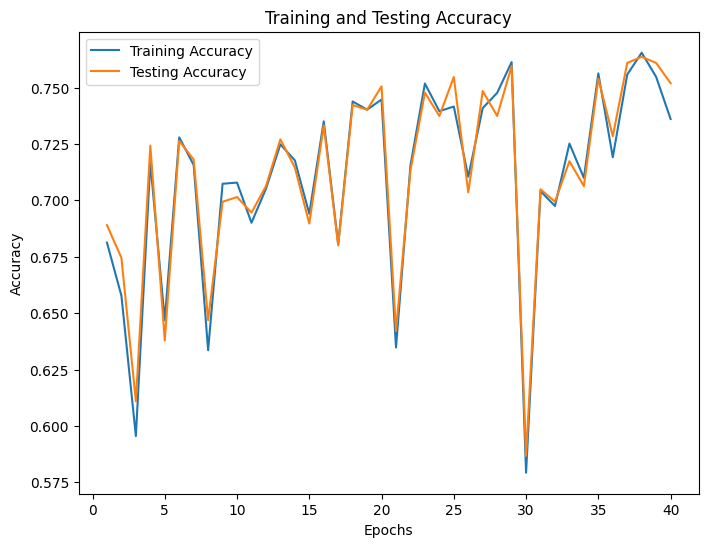

FOLD 2
--------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and sile

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.28it/s]

100%|██████████| 46/46 [00:04<00:00, 10.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 1/40 [00:38<25:16, 38.89s/it]


FC Precision:  0.0
FC Recall:  0.0
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [0 0 0 ... 0 0 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:22<00:00,  8.23it/s]

  5%|▌         | 2/40 [01:22<26:28, 41.79s/it]


FC Precision:  0.6968011126564673
FC Recall:  0.6939058171745153
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 1] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



100%|██████████| 181/181 [00:17<00:00, 10.28it/s]

  8%|▊         | 3/40 [02:02<25:06, 40.71s/it]


FC Precision:  0.7878151260504201
FC Recall:  0.5193905817174516
Labels:  [0 1 1 ... 0 1 0] 

Predicted:  [1 1 1 ... 0 1 0] 




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout i

TRAINING END



  8%|▊         | 3/40 [02:40<33:05, 53.66s/it]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
import torch
for i in Learning_rates:
  LEARNING_RATE = i


# Assuming CombinedDataset is your dataset class that loads images from the "full" directory
  full_dataset = CombinedDataset(folder='Covid_Dataset/full', transform=resizedTransform)

# K-Fold Cross-Validator
  k_folds = 5
  kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

  fold_accuracies = []

# K-Fold Cross Validation model evaluation
  for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
      print(f'FOLD {fold}')
      print('--------------------------------')

    # Create data loaders for training and validation
      train_subset = torch.utils.data.Subset(full_dataset, train_ids)
      val_subset = torch.utils.data.Subset(full_dataset, val_ids)

    # Define data loaders for training and validation
      train_loader = DataLoader(
          train_subset,
          batch_size=BATCH_SIZE,
          shuffle = True
      )
      val_loader = DataLoader(
          val_subset,
          batch_size=BATCH_SIZE,
          shuffle = False
      )

      model = FCNet()

      model.to(DEVICE)

      loss_fun = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

      num_batches_in_train_dataset = len(train_loader)

      training_accuracy_list = []
      testing_accuracy_list = []

    # For the confusion matrix i want the last epoch of testing performance
      last_epoch_predictions = []
      last_epoch_labels = []

      for epoch in tqdm(range(NUM_EPOCHS)):

        model.train()
        for i, data in tqdm(enumerate(train_loader)):
          images, labels = data

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          outputs = model(images)
          loss = loss_fun(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        print('TRAINING END')

      # Calculate accuracy of training and testing at the end of the training epoch


        num_correct_train = 0
        num_samples_train = 0
        model.eval()
      #Evaluate
        with torch.no_grad():

        # num_class_correct = [0 for i in range(NUM_CLASSES)]
        # num_class_samples = [0 for i in range(NUM_CLASSES)]

        # all_predictions = []
        # all_labels = []

          for images, labels in tqdm(train_loader):

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)


            num_samples_train += labels.size(0)
            num_correct_train += (predicted == labels).sum().item()

        training_accuracy = num_correct_train / num_samples_train
          # print(f"\nAccuracy of the network: {acc} %")
        training_accuracy_list.append(training_accuracy)

        num_correct_test = 0
        num_samples_test = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():

        # num_class_correct = [0 for i in range(NUM_CLASSES)]
        # num_class_samples = [0 for i in range(NUM_CLASSES)]



          for images, labels in tqdm(val_loader):

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            all_predictions.append(predicted.cpu().data.numpy())
            all_labels.append(labels.cpu().data.numpy())
          # print('\nPredicted: ',predicted.cpu().data.numpy(),'\n')
          # print('\nLabel: ',labels.cpu().data.numpy(),'\n----------------------------------------')

            num_samples_test += labels.size(0)
            num_correct_test += (predicted == labels).sum().item()

          # if it is the last epoch
            if epoch == NUM_EPOCHS-1:
              last_epoch_predictions.append(predicted.cpu().data.numpy())
              last_epoch_labels.append(labels.cpu().data.numpy())


        testing_accuracy = num_correct_test / num_samples_test
          # print(f"\nAccuracy of the network: {acc} %")
        testing_accuracy_list.append(testing_accuracy)

          # batch_size = images.size(0) # the last batch could have different length
          # for i in range(batch_size):
          #   label = labels[i]
          #   pred = predicted[i]
          #   if (label == pred):
          #     num_class_correct[label] += 1
          #   num_class_samples[label] += 1


      # NEW 18/12/23
        flattened_array1 = np.concatenate(all_predictions).ravel()
        result_list1 = flattened_array1.tolist()

        prediction_list = np.array(result_list1)

        flattened_array2 = np.concatenate(all_labels).ravel()
        result_list2 = flattened_array2.tolist()

        labels_list = np.array(result_list2)


        precision, recall, _, __ = precision_recall_fscore_support(labels_list, prediction_list,average='binary')
        print('\nFC Precision: ', precision)
        print('FC Recall: ', recall)
        precisions.append(precision)
        recalls.append(recall)
        # END

        print('Labels: ',labels_list, '\n')
        print('Predicted: ',prediction_list, '\n')

      fold_accuracies.append(testing_accuracy)
      print(fold_accuracies)

    # Flat the labels and predictions of the last epoch
      flattened_last_epoch_predictions_array = np.concatenate(last_epoch_predictions).ravel()
      flattened_last_epoch_predictions_list = flattened_last_epoch_predictions_array.tolist()
      last_epoch_predictions_list = np.array(flattened_last_epoch_predictions_list)

      flattened_last_epoch_labels_array = np.concatenate(all_labels).ravel()
      flattened_last_epoch_labels_list = flattened_last_epoch_labels_array.tolist()
      last_epoch_labels_list = np.array(flattened_last_epoch_labels_list)

    # The confusion matrix has information of only the last epoch
      plt.figure(figsize=(8, 6))
      conf_matrix = confusion_matrix(last_epoch_labels_list, last_epoch_predictions_list)
      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title('Confusion Matrix')
      plt.show()

    # The accuracy charts take into account the accuracy on all the epochs
      epochs = range(1, NUM_EPOCHS + 1)

      plt.figure(figsize=(8, 6))
      plt.plot(epochs, training_accuracy_list, label='Training Accuracy')
      plt.plot(epochs, testing_accuracy_list, label='Testing Accuracy')
      plt.title('Training and Testing Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()

  print('FINAL ACCURACY: ', sum(fold_accuracies)/5)
  accuracy_changing_learning_rates8.append(sum(fold_accuracies)/5)

  print('FINAL Precision: ', sum(precisions)/len(precisions))
  print('FINAL Recall: ', sum(recalls)/len(recalls))





In [ ]:
accuracy_changing_learning_rates8  # Learning_rates = [0.09] BATCH_SIZE = 32 EPOCH= 40
#FINAL ACCURACY:   [0.7166551485832757]   -->  0.7519004837595025
#FINAL Precision:  0.7400611620795107   ---> 0.8118081180811808
#FINAL Recall: 0.6685082872928176  ---> 0.6312769010043041

# Confusion Matrix
#  553 | 170
#  270 | 484

In [ ]:
accuracy_changing_learning_rates7  # Learning_rates = [0.09] BATCH_SIZE = 32 EPOCH= 30
#FINAL ACCURACY:  [0.7076710435383552]
#FINAL Precision: 0.8351893095768375
#FINAL Recall: 0.5179558011049724

# Confusion Matrix
# 649 | 74
# 349 | 375

In [ ]:
accuracy_changing_learning_rates6  # Learning_rates = [0.09] BATCH_SIZE = 32 EPOCH= 20
#FINAL ACCURACY:  [0.6876295784381479]
#FINAL Precision: 0.8777777777777778
#FINAL Recall: 0.43646408839779005

# Confusion Matrix
# 679 | 44
# 408 | 316

In [ ]:
accuracy_changing_learning_rates5  # Learning_rates = [0.9] BATCH_SIZE = 32
#FINAL ACCURACY:  0.49999751477038873
#FINAL Precision:
#FINAL Recall:

In [ ]:
accuracy_changing_learning_rates4  # Learning_rates = [0.1] BATCH_SIZE = 32
#FINAL ACCURACY:  0.6331924399315224
#FINAL Precision:  0.5679373366405616
#FINAL Recall:  0.6459725679970078

[0.6331924399315224]

In [ ]:
accuracy_changing_learning_rates3  # Learning_rates = [0.09] BATCH_SIZE = 32
#FINAL ACCURACY:  0.669265547739827
#FINAL Precision:  0.6899582408961169
#FINAL Recall:  0.48786497577387794

# Confusion Matrix
# 535+553+714+750+566 | 171+160+10+0+157
# 193+236+479+685+301 | 547+497+243+12+423

[0.669265547739827]

In [ ]:
accuracy_changing_learning_rates2 # Batch_sizes = [40, 48]
# [0.6527984163352231, 0.634686254099434]

In [ ]:
accuracy_changing_learning_rates  # Batch_sizes = [8, 16 , 24]
# [0.5215742782558659, 0.5631974773007731, 0.6230435268849271]